#### Regenerating Joyce's LDV analysis script.

***A part of the analysis is written in R and the LDV extraction/exploration part is written in Python(Python tree implementations are kind of wonky, and I want to use Joyce's tree manipulation code to avoid reinventing the wheel)***

***Step 1*** - Reading in IQtree and Gubbins fasta alignment, breaking up this tree into subtrees to get nodes and associated sample tiplabels. Write this file to "2022-XX-XX_prefix_isolates_by_node.txt". We will read in this file later for Python LDV extraction steps. Generate a variant matrix 2022-XX-XX_prefix_Variant_Matrix.csv from the Gubbins alignment.
    
***Step 2*** - Read in 2022-XX-XX_prefix_isolates_by_node.txt and extract genomes appearing on each subtree nodes. Read in 2022-XX-XX_prefix_Variant_Matrix.csv and extract LDV's that are specific to samples in each nodes.

In [1]:
cd /scratch/esnitkin_root/esnitkin/apirani/Project_VRE_metagenomics_analysis/2022_04_07_Generate_LDV_scripts

In [2]:
# {R}
# VREfm extract geneomes for each nodes commands

library(readxl)   
library(treeio)
library(ape)
library(ggtree)
library(ggplot2)
library(randomcoloR)
library(phytools)
library(cowplot)
library(RColorBrewer)
prefix = "VREfm"
setwd("/scratch/esnitkin_root/esnitkin/apirani/Project_VRE_metagenomics_analysis/2022_04_07_Generate_LDV_scripts")
iqtree = read.iqtree("2021_06_12_16_42_32_Aus0004_genome_aln_w_alt_allele_unmapped_exclude_controls.treefile")
phylo = iqtree@phylo
phylo$bootstrap = phylo$node.label
# Not sure what is happening in the below line of code but seems like renaming node label. But why and How?
phylo$node.label = c(min(phylo$edge[phylo$edge[,2] > length(phylo$tip.label),2]) - 1, phylo$edge[phylo$edge[,2] > length(phylo$tip.label),2])

vrefm_st = subtrees(phylo)

node_genome_mat = matrix(NA, nrow = length(phylo$tip.label), ncol = length(vrefm_st), dimnames = list(NULL, 1:length(vrefm_st)))
for (n in 1:length(vrefm_st)){
  #print(n)
  node_genome_mat[1:length(vrefm_st[[n]]$tip.label),n] = vrefm_st[[n]]$tip.label
}

filename = paste(gsub(":", "-", Sys.Date()),"_", prefix,"_isolates_by_node.txt",sep="")
write.table(node_genome_mat, file = filename, quote = F, sep = "\t", row.names = F, col.names = T)

setwd("/scratch/esnitkin_root/esnitkin/apirani/Project_VRE_metagenomics_analysis/2022_04_07_Generate_LDV_scripts")
dna = read.dna("2021_06_12_16_42_32_Aus0004_genome_aln_w_alt_allele_unmapped_exclude_controls.filtered_polymorphic_sites.fasta", format = "fasta")
var = read.table("2021_06_12_16_42_32_Aus0004_genome_aln_w_alt_allele_unmapped_exclude_controls.summary_of_snp_distribution.vcf")
dna2 = dna
colnames(dna2) = var$V2
dna2 = as.character(dna2)
dna2 = apply(dna2, 1:2, toupper)
var_pos2 = dna2[,apply(dna2, 2, FUN = function(x){sum(x %in% c("N", "-")) == 0})]
filename = paste(gsub(":", "-", Sys.Date()),"_", prefix,"_Variant_Matrix.csv",sep="")
write.csv(var_pos2, file = filename)


count    151.000000
mean      12.807947
std       24.989522
min        2.000000
25%        2.000000
50%        4.000000
75%       10.500000
max      153.000000
dtype: float64

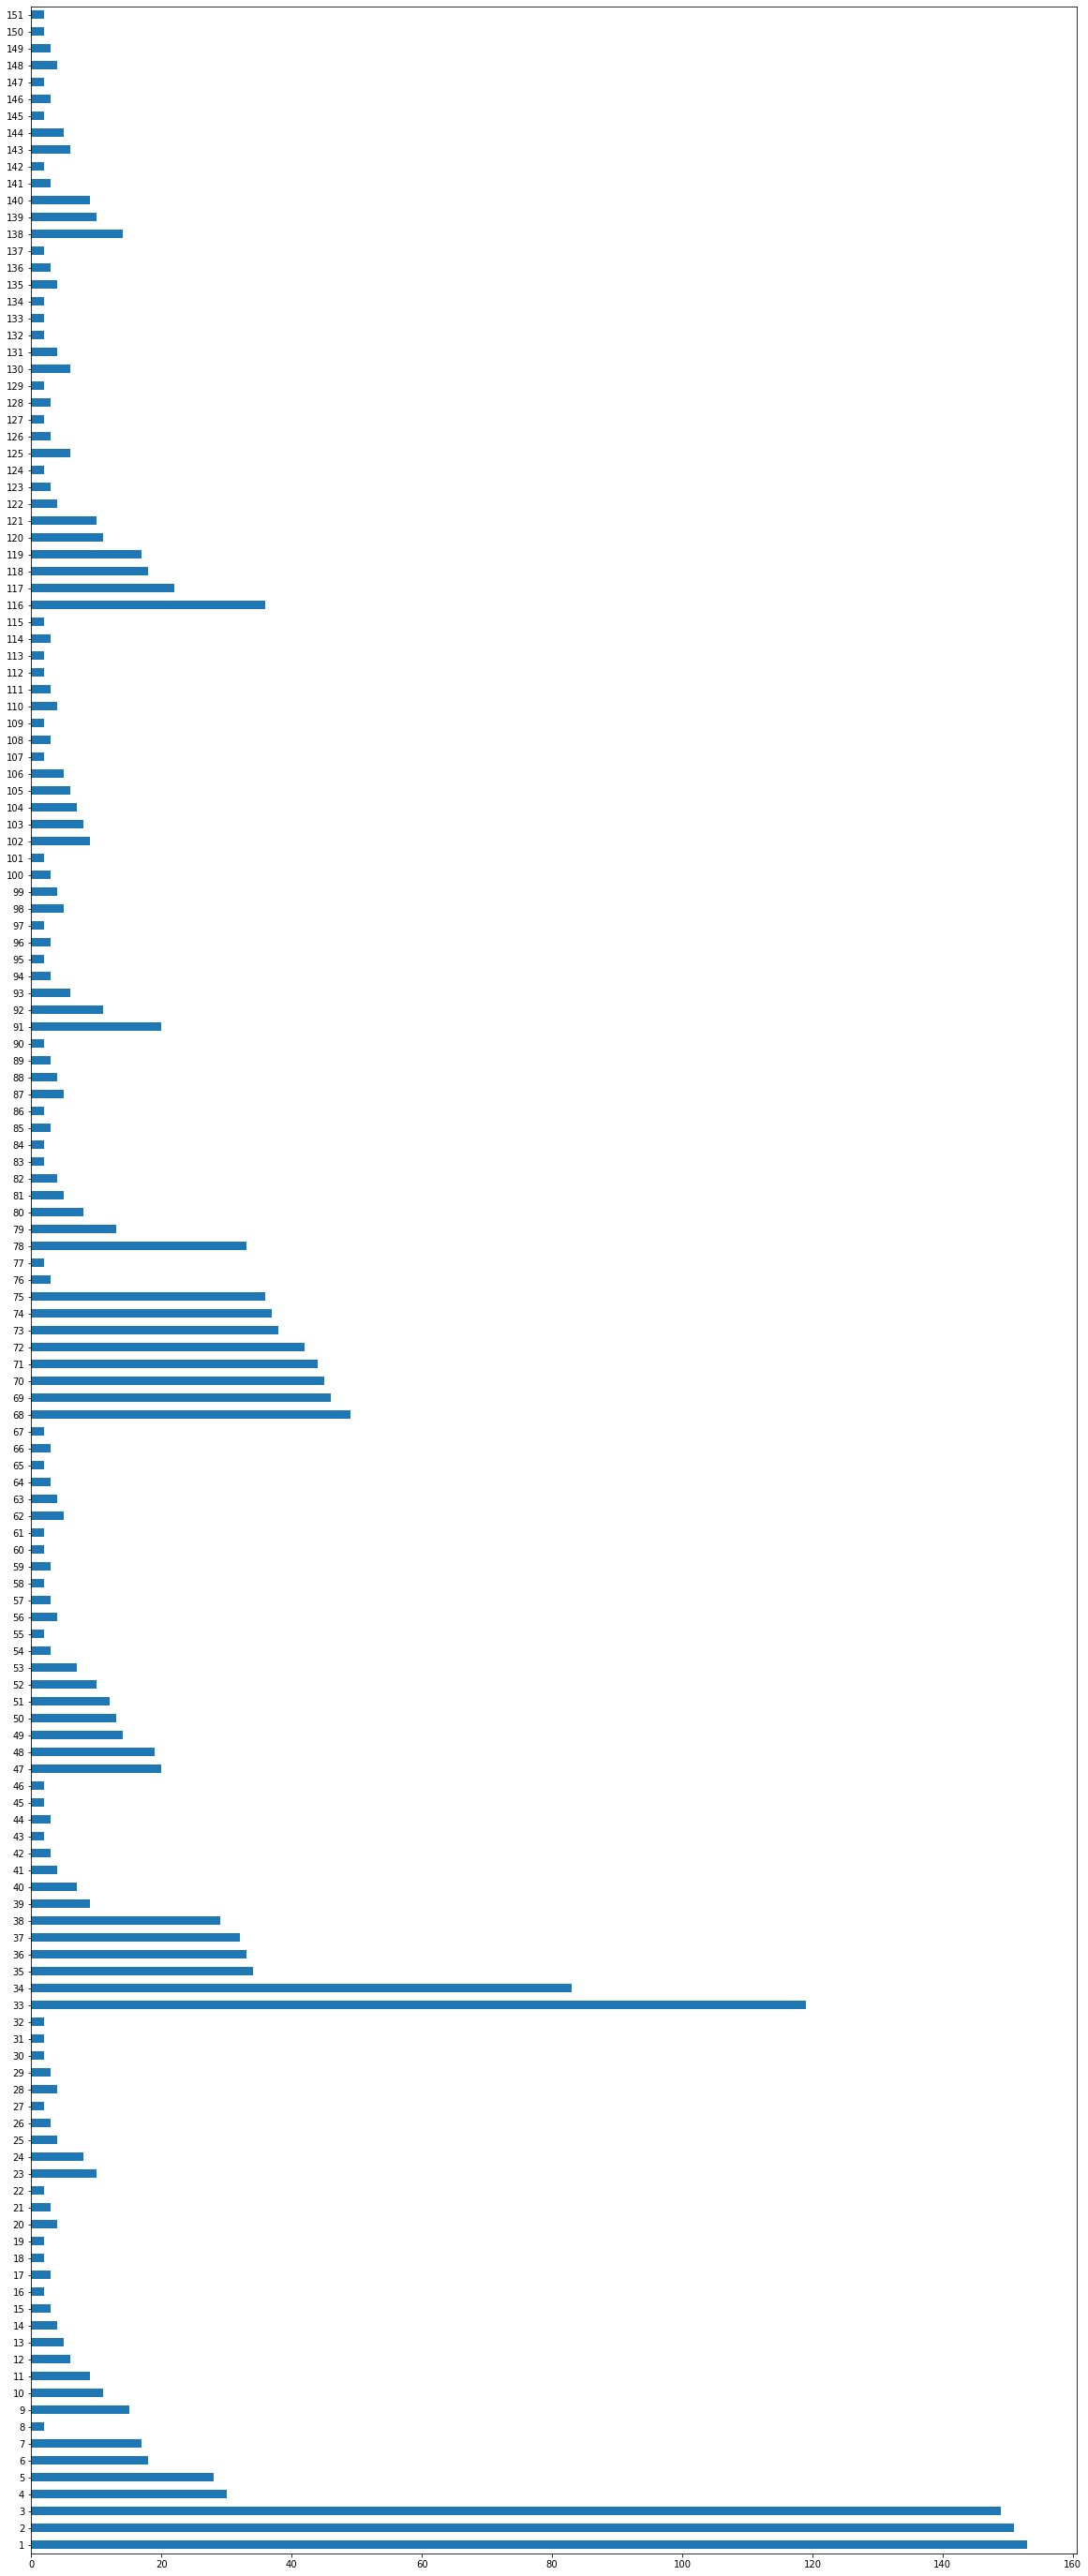

In [2]:
# {Python}
# Read isolates by Node file and create a dictionary containing Node # and the geneomes that appeat on these nodes.
import numpy as np
import pandas as pd
from IPython.display import HTML
import os
import readline
import argparse
from itertools import islice
import subprocess
import matplotlib.pyplot as plt
os.chdir("/scratch/esnitkin_root/esnitkin/apirani/Project_VRE_metagenomics_analysis/2022_04_07_Generate_LDV_scripts")
Genomes_in_node = pd.read_csv("2022-04-12_VREfm_isolates_by_node.txt", sep='\t', header=0, dtype = str)
pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.rcParams['figure.figsize'] = [20, 50]
Genomes_in_node.count().plot(kind="barh")
Genomes_in_node.count().describe()

In [38]:
from collections import defaultdict
# Read in the Gubbins Variant matrix generated by R script
Gubbins_Variants = pd.read_csv("2022-04-12_VREfm_Variant_Matrix.csv", sep=',', header=0, dtype = str, index_col=0)

# Get the names of all the Samples in the Matrix. 
All_samples = Gubbins_Variants.index

Node_shared_LDV = {}
Node_LDV_Base = {}

for (columnName, columnData) in Genomes_in_node.iteritems():
    # Drop column values that are nan. 
    columnData_DropNA = [x for x in columnData.tolist() if pd.isnull(x) == False or str(x) != 'nan']
    # From the Gubbins variant matrix extract sample variant  information (rows) specific to this Node.
    Node_in_question = Gubbins_Variants.loc[columnData_DropNA]
    # For each column (Position), Make sure that the variant observed are the same across the samples i.e length of unique observation should be equal to 1. Node_in_question_shared_uniq will contain posistions where the variant was same in all the samples.
    Node_in_question_shared_uniq = Node_in_question.columns[(Node_in_question.nunique() == 1)]
    # Insert this information in a dictionary Node_shared_LDV - will be used to compare these positions with other sample variant information. Where we will check if the variant is different that what was called in other samples.
    # Hope i am making sense here :)    
    Node_shared_LDV[columnName] = Node_in_question_shared_uniq
    # Extract Sample names that are not in this node.
    remaining_samples = [i for i in All_samples if i not in columnData_DropNA]
    # Extract rows that are not in the Node.
    Node_not_in_question = Gubbins_Variants.loc[remaining_samples]
    
    
    Node_LDV_Base_string = "Node - %s" % columnName
    # Extract Positions of Node in question, check if they have the same Nucleotide in Node not in question dataframe, These will be your LDVs for your Node in question
    # Basically its a simple loop where I am checking if the position for the given node in question have a different allele than the other samples for the same position.
    # This would mean that this position is unique and specific for the samples located on the Node.
    for pos in  Node_shared_LDV[columnName]:
        if Node_in_question[pos].unique() not in Node_not_in_question[pos].unique():
            Node_LDV_Base_string = Node_LDV_Base_string + ",%s - %s" %  (pos, Node_in_question[pos].unique())
            #case = {pos: str(Node_in_question[pos].unique())}
            #Node_LDV_Base[columnName].append(pos)
            #Node_LDV_Base[columnName] = [Node_LDV_Base[columnName],pos]
            #Node_LDV_Base[columnName][pos].append(Node_in_question[pos].unique())
            #Node_LDV_Base[columnName].update(pos)
    print('Node : ', columnName)
    #print('Genomes in Node : ', columnData_DropNA)
    print('# of Genomes in Node : ', len(columnData_DropNA))
    #print('Genomes Not in Node : ', remaining_samples)
    print('# of Genomes Not in Node : ', len(remaining_samples))
    print (Node_LDV_Base_string)

Node :  1
# of Genomes in Node :  153
# of Genomes Not in Node :  0
Node - 1
Node :  2
# of Genomes in Node :  151
# of Genomes Not in Node :  2
Node - 2,2607470 - ['C'],2633822 - ['G']
Node :  3
# of Genomes in Node :  149
# of Genomes Not in Node :  4
Node - 3
Node :  4
# of Genomes in Node :  30
# of Genomes Not in Node :  123
Node - 4,674001 - ['A'],696537 - ['T'],724654 - ['G'],2359427 - ['G']
Node :  5
# of Genomes in Node :  28
# of Genomes Not in Node :  125
Node - 5
Node :  6
# of Genomes in Node :  18
# of Genomes Not in Node :  135
Node - 6,1580221 - ['T']
Node :  7
# of Genomes in Node :  17
# of Genomes Not in Node :  136
Node - 7
Node :  8
# of Genomes in Node :  2
# of Genomes Not in Node :  151
Node - 8,531614 - ['T'],1227758 - ['A'],1897460 - ['T'],2688889 - ['G']
Node :  9
# of Genomes in Node :  15
# of Genomes Not in Node :  138
Node - 9
Node :  10
# of Genomes in Node :  11
# of Genomes Not in Node :  142
Node - 10
Node :  11
# of Genomes in Node :  9
# of Genomes 

In [ ]:
Node_shared_LDV = {}
for (columnName, columnData) in Genomes_in_node.iteritems():
    print('Node : ', columnName)
    columnData_DropNA = [x for x in columnData.tolist() if pd.isnull(x) == False or str(x) != 'nan']
    #print('Genomes in Node : ', columnData_DropNA)
    #print('# of Genomes in Node : ', len(columnData_DropNA))
    
    Node_in_question = Gubbins_Variants_test.loc[columnData_DropNA]
    Node_in_question_shared_uniq = Node_in_question.columns[(Node_in_question.nunique() == 1)]
    #print (len(Node_in_question_shared_uniq))
    #print (Node_in_question_shared_uniq)
    Node_shared_LDV[columnName] = Node_in_question_shared_uniq
    #print (Node_shared_LDV)
    remaining_samples = [i for i in All_samples if i not in columnData_DropNA]
    Node_not_in_question = Gubbins_Variants_test.loc[remaining_samples]
    
    #print (Node_not_in_question)
    #print('Genomes Not in Node : ', remaining_samples)
    
    Node_LDV_Base = {}
    Node_LDV_Base_string = "Node - %s" % columnName
    # Extract Positions of Node in question, check if they have the same Nucleotide in Node not in question dataframe, These will be your LDVs for your Node in question
    for pos in  Node_shared_LDV[columnName]:
        if Node_in_question[pos].unique() not in Node_not_in_question[pos].unique():
            #Node_LDV_Base[columnName][pos] = Node_shared_LDV[pos]
            Node_LDV_Base_string = Node_LDV_Base_string + ",%s - %s" %  (pos, Node_in_question[pos].unique())
            #print (Node_shared_LDV[columnName][pos])
            #print (Node_in_question[pos].unique())
    print (Node_LDV_Base_string)
#     if len(Node_LDV_Base[columnName]) > 1:
#         print (Node_LDV_Base[columnName])
#     for key, pos in  Node_shared_LDV[columnName].items:
        
#     print (Gubbins_Variants_test.loc[['1929-4036-0-GVRE', '6950-4109-0-RVRE']])
#     if len(columnData_DropNA) == 2:
#         print (Gubbins_Variants_test.loc[columnData_DropNA])
    #print (Gubbins_Variants.loc[['CP003351.1', '1016-2017-0-RVRE', '5948-6048-14-RVRE']])
    #print (Gubbins_Variants.loc[Gubbins_Variants['Unnamed: 0'].isin([columnData])])
#     if len(columnData.tolist()) < 
#     print (Gubbins_Variants_test.loc[[columnData.tolist()]])

In [12]:
# {R}
# Cdiff extract geneomes for each nodes commands

library(readxl)   
library(treeio)
library(ape)
library(ggtree)
library(ggplot2)
library(randomcoloR)
library(phytools)
library(cowplot)
library(RColorBrewer)

prefix = "cdiff"
setwd("/scratch/esnitkin_root/esnitkin/apirani/Project_VRE_metagenomics_analysis/2022_04_07_Generate_LDV_scripts")

iqtree = read.tree("/nfs/esnitkin/Project_Cdiff/Sequence_data/Project_U01_SB/consensus/2020_05_29_12_15_15_core_results/gubbins/iqtree_masked_wga/2020_05_29_12_15_15_cdiff_630_genome_aln_w_alt_allele_unmapped.treefile")
# phylo = iqtree@phylo
# phylo$bootstrap = phylo$node.label
# # Not sure what is happening in the below line of code but seems like renaming node label. But why and How?
# phylo$node.label = c(min(phylo$edge[phylo$edge[,2] > length(phylo$tip.label),2]) - 1, phylo$edge[phylo$edge[,2] > length(phylo$tip.label),2])
iqtree_converted <- as.treedata(iqtree)
phylo = iqtree_converted@phylo
phylo$bootstrap = phylo$node.label
phylo$node.label = c(min(phylo$edge[phylo$edge[,2] > length(phylo$tip.label),2]) - 1, phylo$edge[phylo$edge[,2] > length(phylo$tip.label),2])

sbtrees = subtrees(phylo)

node_genome_mat = matrix(NA, nrow = length(phylo$tip.label), ncol = length(sbtrees), dimnames = list(NULL, 1:length(sbtrees)))
for (n in 1:length(sbtrees)){
  #print(n)
  node_genome_mat[1:length(sbtrees[[n]]$tip.label),n] = sbtrees[[n]]$tip.label
}

filename = paste(gsub(":", "-", Sys.Date()),"_", prefix,"_isolates_by_node.txt",sep="")
write.table(node_genome_mat, file = filename, quote = F, sep = "\t", row.names = F, col.names = T)

setwd("/scratch/esnitkin_root/esnitkin/apirani/Project_VRE_metagenomics_analysis/2022_04_07_Generate_LDV_scripts")
dna = read.dna("2020_05_29_12_15_15_cdiff_630_genome_aln_w_alt_allele_unmapped.filtered_polymorphic_sites.fasta", format = "fasta")
var = read.table("2020_05_29_12_15_15_cdiff_630_genome_aln_w_alt_allele_unmapped.summary_of_snp_distribution.vcf")
dna2 = dna
colnames(dna2) = var$V2
dna2 = as.character(dna2)
dna2 = apply(dna2, 1:2, toupper)
var_pos2 = dna2[,apply(dna2, 2, FUN = function(x){sum(x %in% c("N", "-")) == 0})]
filename = paste(gsub(":", "-", Sys.Date()),"_", prefix,"_Variant_Matrix.csv",sep="")
write.csv(var_pos2, file = filename)

count    1380.000000
mean       31.723913
std       139.456715
min         2.000000
25%         2.000000
50%         5.000000
75%        12.000000
max      1382.000000
dtype: float64

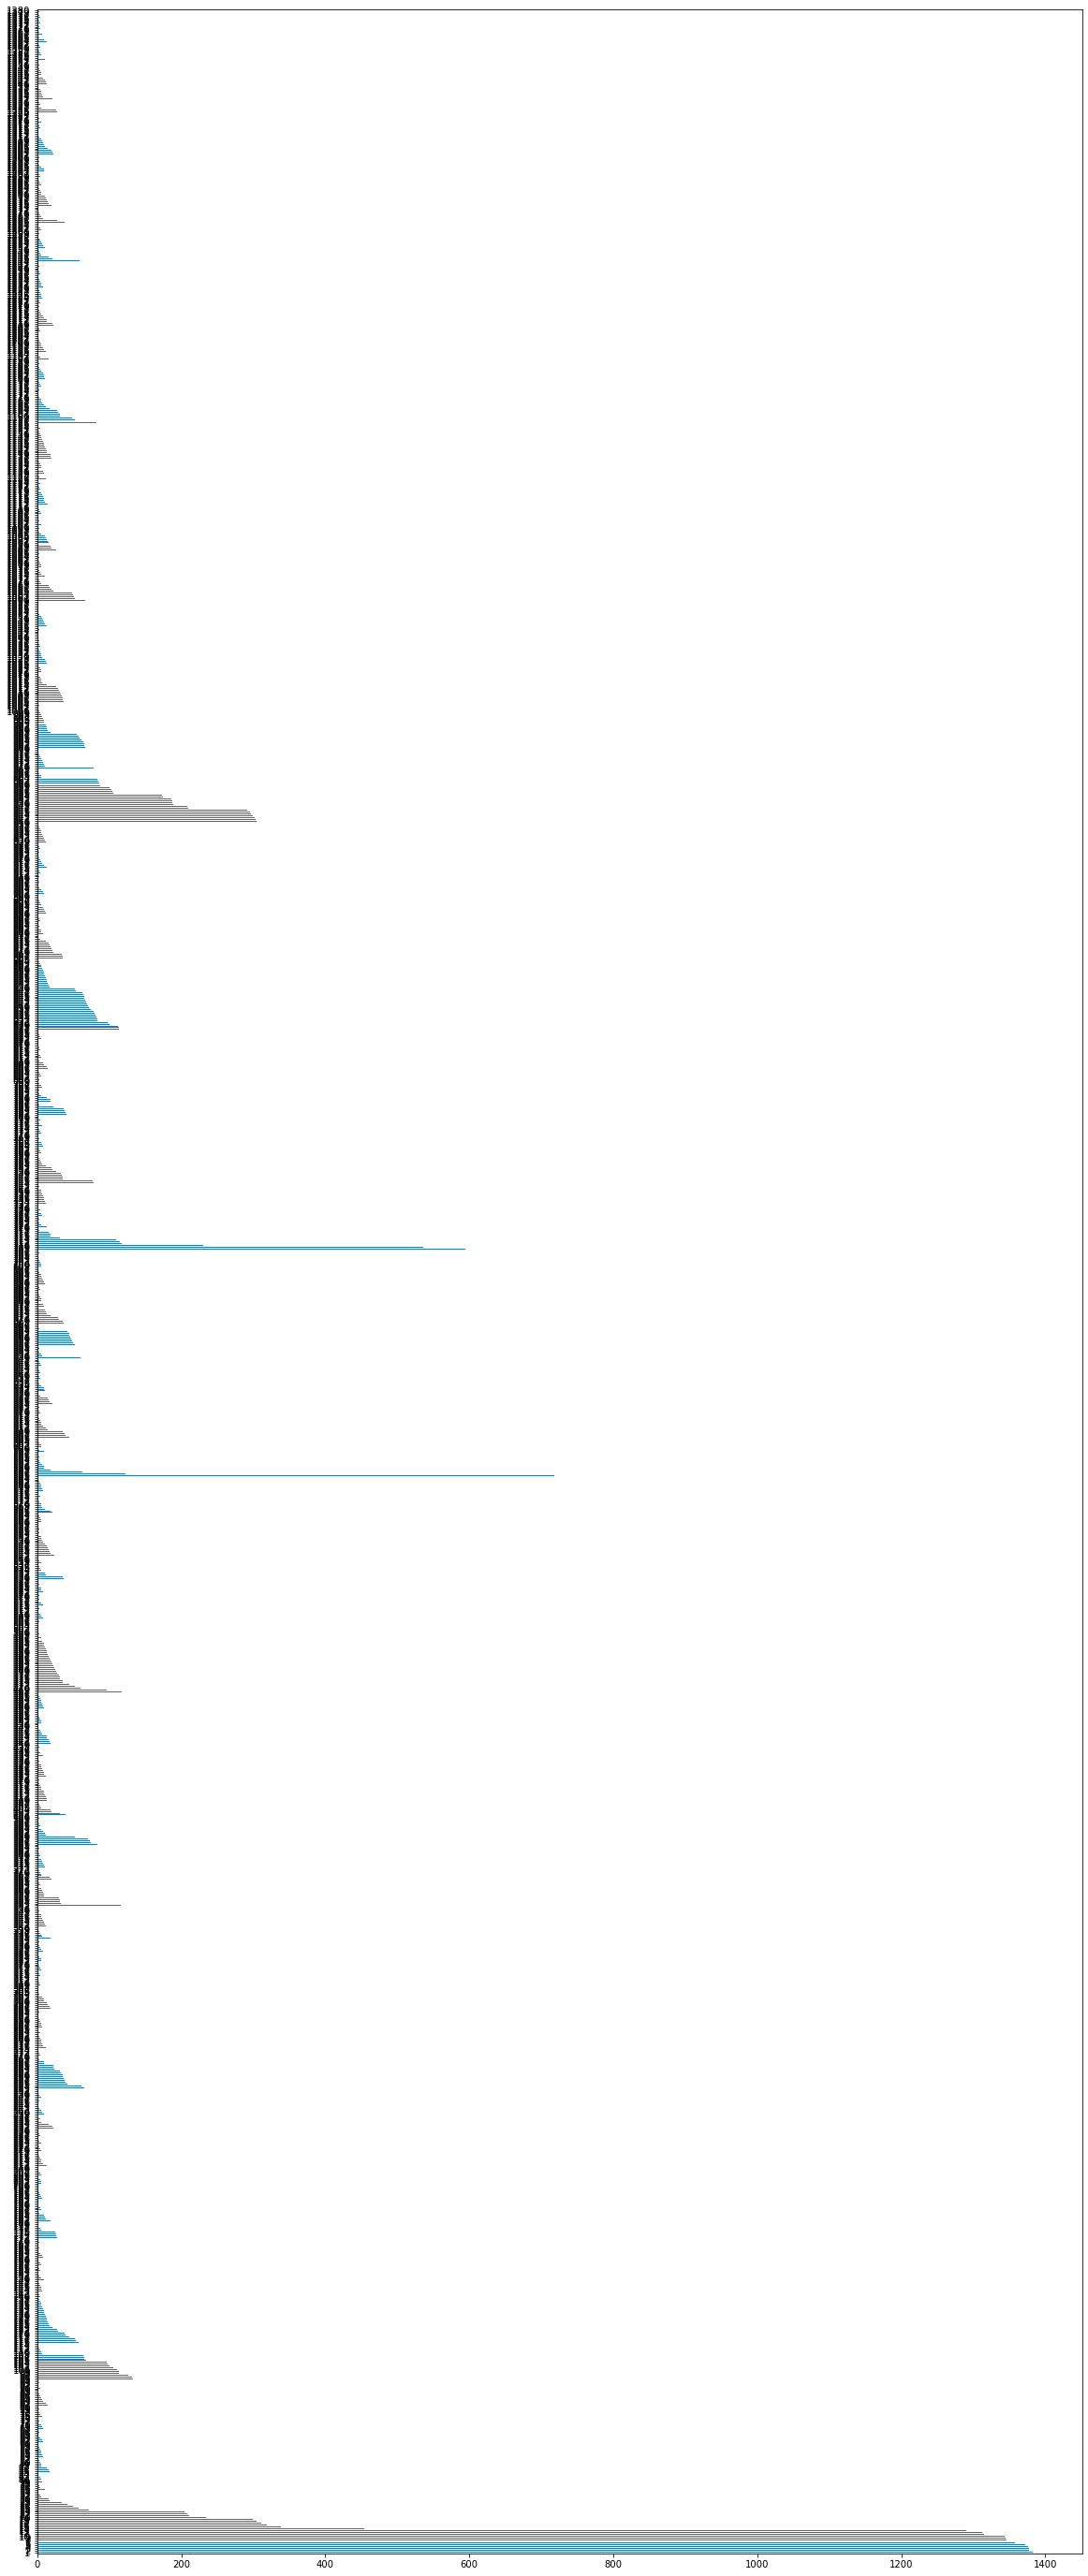

In [2]:
# {Python}
# Read isolates by Node file and create a dictionary containing Node # and the geneomes that appeat on these nodes.
import numpy as np
import pandas as pd
from IPython.display import HTML
import os
import readline
import argparse
from itertools import islice
import subprocess
import matplotlib.pyplot as plt
os.chdir("/scratch/esnitkin_root/esnitkin/apirani/Project_VRE_metagenomics_analysis/2022_04_07_Generate_LDV_scripts")
Genomes_in_node = pd.read_csv("2022-04-12_cdiff_isolates_by_node.txt", sep='\t', header=0, dtype = str)
pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.rcParams['figure.figsize'] = [20, 50]
Genomes_in_node.count().plot(kind="barh")
Genomes_in_node.count().describe()

In [8]:
# Read in the Gubbins Variant matrix generated by R script
Gubbins_Variants = pd.read_csv("2022-04-12_cdiff_Variant_Matrix.csv", sep=',', header=0, dtype = str, index_col=0)

# Get the names of all the Samples in the Matrix. 
All_samples = Gubbins_Variants.index


Node_shared_LDV = {}
Node_LDV_Base = {}

for (columnName, columnData) in Genomes_in_node.iteritems():
    # Drop column values that are nan. 
    columnData_DropNA = [x for x in columnData.tolist() if pd.isnull(x) == False or str(x) != 'nan']
    # From the Gubbins variant matrix extract sample variant  information (rows) specific to this Node.
    Node_in_question = Gubbins_Variants.loc[columnData_DropNA]
    # For each column (Position), Make sure that the variant observed are the same across the samples i.e length of unique observation should be equal to 1. Node_in_question_shared_uniq will contain posistions where the variant was same in all the samples.
    Node_in_question_shared_uniq = Node_in_question.columns[(Node_in_question.nunique() == 1)]
    # Insert this information in a dictionary Node_shared_LDV - will be used to compare these positions with other sample variant information. Where we will check if the variant is different that what was called in other samples.
    # Hope i am making sense here :)    
    Node_shared_LDV[columnName] = Node_in_question_shared_uniq
    # Extract Sample names that are not in this node.
    remaining_samples = [i for i in All_samples if i not in columnData_DropNA]
    # Extract rows that are not in the Node.
    Node_not_in_question = Gubbins_Variants.loc[remaining_samples]
    
    
    Node_LDV_Base_string = "Node - %s" % columnName
    # Extract Positions of Node in question, check if they have the same Nucleotide in Node not in question dataframe, These will be your LDVs for your Node in question
    # Basically its a simple loop where I am checking if the position for the given node in question have a different allele than the other samples for the same position.
    # This would mean that this position is unique and specific for the samples located on the Node.
    for pos in  Node_shared_LDV[columnName]:
        if Node_in_question[pos].unique() not in Node_not_in_question[pos].unique():
            Node_LDV_Base_string = Node_LDV_Base_string + ",%s - %s" %  (pos, Node_in_question[pos].unique())
            #case = {pos: str(Node_in_question[pos].unique())}
            #Node_LDV_Base[columnName].append(pos)
            #Node_LDV_Base[columnName] = [Node_LDV_Base[columnName],pos]
            #Node_LDV_Base[columnName][pos].append(Node_in_question[pos].unique())
            #Node_LDV_Base[columnName].update(pos)
    print('Node : ', columnName)
    #print('Genomes in Node : ', columnData_DropNA)
    print('# of Genomes in Node : ', len(columnData_DropNA))
    #print('Genomes Not in Node : ', remaining_samples)
    print('# of Genomes Not in Node : ', len(remaining_samples))
    print (Node_LDV_Base_string)

Node :  1
# of Genomes in Node :  1382
# of Genomes Not in Node :  0
Node - 1
Node :  2
# of Genomes in Node :  1378
# of Genomes Not in Node :  4
Node - 2
Node :  3
# of Genomes in Node :  1377
# of Genomes Not in Node :  5
Node - 3
Node :  4
# of Genomes in Node :  1376
# of Genomes Not in Node :  6
Node - 4
Node :  5
# of Genomes in Node :  1372
# of Genomes Not in Node :  10
Node - 5
Node :  6
# of Genomes in Node :  1358
# of Genomes Not in Node :  24
Node - 6
Node :  7
# of Genomes in Node :  1357
# of Genomes Not in Node :  25
Node - 7
Node :  8
# of Genomes in Node :  1346
# of Genomes Not in Node :  36
Node - 8
Node :  9
# of Genomes in Node :  1345
# of Genomes Not in Node :  37
Node - 9
Node :  10
# of Genomes in Node :  1343
# of Genomes Not in Node :  39
Node - 10
Node :  11
# of Genomes in Node :  1315
# of Genomes Not in Node :  67
Node - 11
Node :  12
# of Genomes in Node :  1313
# of Genomes Not in Node :  69
Node - 12
Node :  13
# of Genomes in Node :  1290
# of Genom

In [ ]:
gi|126697566|ref|NC_009089.1|